<a href="https://colab.research.google.com/github/technisekai/wordCloud_analysis/blob/main/wordClodu_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preparing Library

In [93]:
!pip install Sastrawi

     |████████████████████████████████| 209 kB 5.5 MB/s 


In [124]:
!gdown --id 19nlMainHfItPZ4_9K1yS3WZgk8nJW1p5
!gdown --id 1cINKFxiSycaOwVY5O5SPAxEwuhKRvqSz

Downloading...
From: https://drive.google.com/uc?id=19nlMainHfItPZ4_9K1yS3WZgk8nJW1p5
To: /content/stopwordbahasa.csv
100% 6.45k/6.45k [00:00<00:00, 9.57MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cINKFxiSycaOwVY5O5SPAxEwuhKRvqSz
To: /content/new_kamusalay.csv
100% 286k/286k [00:00<00:00, 34.8MB/s]


In [125]:
import cv2
import re
import pandas as pd
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# preparing var to stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# preparing normalize word
alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
# preparing remove stopword
id_stopword_dict = pd.read_csv('stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

# 2. Preparing Image

In [ ]:
# download image
!wget https://i.pinimg.com/474x/4c/f1/7a/4cf17a9f1cba43426100e3c45aead9fe--moving-gif-sign-of-love.jpg

In [111]:
# load image
img = cv2.imread('/content/4cf17a9f1cba43426100e3c45aead9fe--moving-gif-sign-of-love.jpg')
# img to gray
img_to_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(thresh, love_mask) = cv2.threshold(img_to_gray, 100, 255, cv2.THRESH_BINARY)

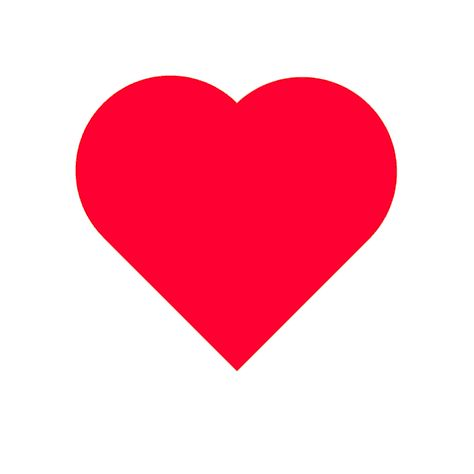

In [112]:
# show original image
cv2_imshow(img)

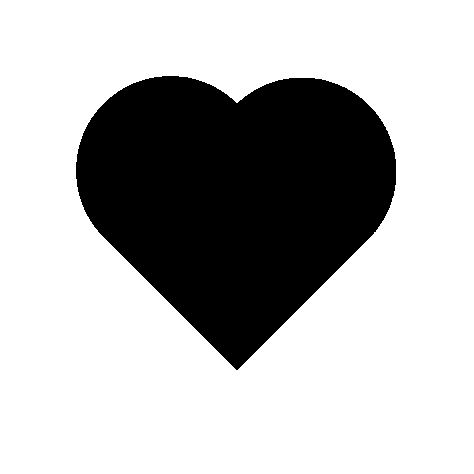

In [113]:
# show mask result
cv2_imshow(love_mask)

# 3. Data Preprocessing

## 3.1 Whatsapp text to dataframe

In [14]:
#split date
def startsWithDateTime(s):
    patterns = ['([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]) -', '([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}) ([0-9][0-9]).([0-9][0-9]) -']
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False
    
#split author wurh regex
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                                # First Name
        '([\w]+[\s]+[\w]+):',                      # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',            # First Name + Middle Name + Last Name
        '([\w\W]+[\s\W]+[\w\W]+[\s\W]+[\w\W]+):',  # First Name + Middle Name + Last Name that maybe have non-character
        '\+?([ -]?\d+)+|\(\d+\)([ -]\d+)'          # Mobile Number (indonesia)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False
    
#split time, message, and author
def getDataPoint(line):
	#split time
    splitLine = line.split(' - ')
    dateTime = splitLine[0]
    date, time = dateTime.split(' ')
    #split message
    message = ' '.join(splitLine[1:])
    
    if startsWithAuthor(message):
        splitMessage = message.split(': ')
        author = splitMessage[0] #author
        message = ' '.join(splitMessage[1:]) #message
    else:
        author = None
    return date, time, author, message

## 3.2 Data cleansing

In [96]:
# lowercase
def lowercase(text):
    return text.lower()

# remove unnecessary char
def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
 
# remove non-alphanumeruic   
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

# stemming
def stemming(text):
    return stemmer.stem(text)

# normalization
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

# remove stopword
def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

In [100]:
# preprocessing using function defined above
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 3
    text = normalize_alay(text) # 4
    #text = stemming(text) # 5
    text = remove_stopword(text) # 6
    return text

*you can uncomment stemming for good result if want, but preprocessing text takes more time*

## 3.3 cleaning whatsapp text

In [98]:
#clean
def clean(path_file):
	parsedData = []
	conversationPath = path_file    #path ke file
	with open(conversationPath, encoding="latin1") as fp:
		fp.readline()
			
		messageBuffer = []
		date, time, author = None, None, None
		
		while True:
			line = fp.readline() 
			if not line:
				break
			line = line.strip()
			if startsWithDateTime(line):
				if len(messageBuffer) > 0:
					parsedData.append([date, time, author, ' '.join(messageBuffer)])
     
				messageBuffer.clear()
				date, time, author, message = getDataPoint(line)
				messageBuffer.append(message)
			else:
				messageBuffer.append(line)
				
	#to pandas
	df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
	
	#apply next step preprocess
	df['Message'] = df['Message'].apply(preprocess)
	
	#remove value with None
	for i in range(len(df["Message"])):
		if '' == df["Message"][i]:
			df["Message"][i] = None
		if 'media omitted' == df["Message"][i]:
			df["Message"][i] = None
		 
	#drop None
	df.dropna(inplace=True)
	df.reset_index(drop=True, inplace=True)
	
	#take column author and message
	df = df.drop(columns=['Date','Time'])
	
	return df

In [116]:
whatsapp_chat = '/content/WhatsApp Chat with ..'  # change with your file
df = clean(whatsapp_chat)
# show result
df.head()

# 4. Visualize with WordCloud

In [118]:
# make string from dataset
df_to_string = pd.Series(df['Message']).str.cat(sep=' ')

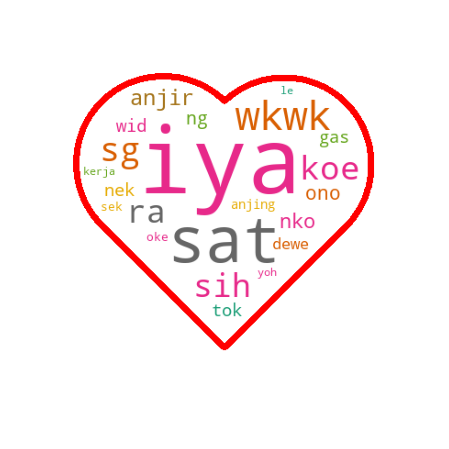

In [120]:
# make wordclous based image and string
wordcloud = WordCloud(width=5000, height=1400, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=100, min_font_size=12,
                      mask=love_mask, contour_width=10, contour_color='red',
                      max_words=100).generate(df_to_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()